# Data Processing and Performance Exploration - Data Analysis Course

**Welcome** to the Data Processing and Performance Exploration task! In this assignment, you will explore the **Big Sales data** dataset from [Kaggle](https://www.kaggle.com/datasets/pigment/big-sales-data/data) (we only need the Books_rating.csv from there), focusing on calculating a "dummy sentiment score" measure using different data processing tools. The goal is to analyze the memory usage and execution time of these tools—**Pandas**, **Dask**, and **PySpark**—and compare their performance.

**Exploration and Tools**  
Explore the following tools to process large datasets and measure performance:

- [Pandas Documentation](https://pandas.pydata.org/)
- [Dask Documentation](https://dask.org/)
- [PySpark Documentation](https://spark.apache.org/docs/latest/api/python/)

You will be using Python (specifically **Pandas**, **Dask**, and **PySpark**) to handle the dataset and compute the sentiment score. Be sure to pay attention to memory usage and processing time during the computations.

**Task Description**  
1. Download the **Books_rating.csv** from the following Kaggle dataset: [Big Sales Data](https://www.kaggle.com/datasets/pigment/big-sales-data/data).
2. Create a function `process_text(text)` that computes a **dummy sentiment score** for each review. The sentiment score should be calculated as the sum of the Unicode values of all characters in the review, modulo 100. Here’s a template for the function:

    ```python
    import re

    def process_text(text):
        words = re.findall(r'\w+', text)  # Tokenize words
        word_count = len(words)  # Count words
        sentiment_score = sum(ord(c) for c in text) % 100  # Fake sentiment calculation
        return word_count, sentiment_score
    ```
3. Perform the calculation using **Pandas**, **Dask**, and **PySpark** and compare the **memory usage** and **execution time** of each tool.
4. Explore the trade-offs between each library in terms of performance, scalability, and ease of use.
5. **Visualizations**:
    - Create visualizations for **execution time** and **memory usage** for each library. Use appropriate libraries such as **Matplotlib** or **Seaborn** to plot your results.
    - Use the `%%time` magic command in Jupyter to measure execution time for each tool.
    - For **Dask**, consider using `dask.delayed` or similar techniques for more efficient parallel computation. Experiment with different Dask functions and compare the results.
  
**Metrics to Analyze:**
- **Memory Usage**: How much memory does each library consume when processing the data? Use memory profiling tools to measure the memory footprint.
- **Execution Time**: Measure how long it takes for each tool to complete the sentiment score calculation. Use appropriate timing functions (e.g., `time.time()` or `datetime.now()`) or Jupyter's `%%time` magic command.

**Submission Instructions**  
Upload your solution to GitHub, adding the notebook and any related files to your existing project repository.

**Visualizations and Figures**  
For each tool, include visualizations (e.g., execution time and memory usage comparisons) that clearly show how each tool performs in terms of resource usage.

If you are interested in the topic, check out:
http://daslab.seas.harvard.edu/classes/cs265/


In [16]:
import dask
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

In [17]:
import re
import time
from memory_profiler import memory_usage

def process_text(text):
    if not isinstance(text, str):
        text = ""
    words = re.findall(r'\w+', text)
    return int(len(words)), int(sum(ord(c) for c in text) % 100)

In [18]:
df = pd.read_csv("Books_rating.csv")

In [19]:
df['review/text'] = df['review/text'].astype(str)

In [20]:
#sample_df = df.copy() - My laptop is not strong enough for this :(
sample_df = df.sample(n=5000, random_state=42).copy()

start_time = time.time()
mem_usage = memory_usage((sample_df['review/text'].apply, (process_text,)), max_usage=True)
sample_df[['word_count', 'sentiment_score']] = sample_df['review/text'].apply(process_text).apply(pd.Series)
pandas_time = time.time() - start_time

print(f"Pandas time (sample): {pandas_time:.2f} sec, Max memory: {mem_usage:.2f} MiB")
print(sample_df[['word_count', 'sentiment_score']])


Pandas time (sample): 1.27 sec, Max memory: 3852.89 MiB
         word_count  sentiment_score
2945667         169               63
2352586          21               17
1531260         167               73
941910           28               13
2582125          49               50
...             ...              ...
1287132          49               44
835402           36               60
249829          338               10
587466           56               10
328811           76               33

[5000 rows x 2 columns]


In [21]:
import dask.dataframe as dd
from pandas.api.types import is_string_dtype

text_ddf = dd.from_pandas(sample_df[['review/text']], npartitions=4)

In [22]:
meta = pd.DataFrame({
    'word_count': pd.Series(dtype='int64'),
    'sentiment_score': pd.Series(dtype='int64')
})


start_time = time.time()
mapped_df = text_ddf.map(process_text, meta=meta)
dask_result = mapped_df.compute()
dask_time = time.time() - start_time

print(f"Dask time: {dask_time:.2f} sec")
print(dask_result)

Dask time: 0.71 sec
        review/text
1002       (91, 85)
1174      (175, 93)
1297      (349, 76)
1366      (421, 40)
1954       (20, 58)
...             ...
2995679   (103, 29)
2996729    (127, 1)
2997402   (168, 51)
2997439    (32, 32)
2997667    (42, 30)

[5000 rows x 1 columns]


In [23]:
import gc

for var in ["features_df", "features_ddf", "result", "df"]:
    if var in globals():
        del globals()[var]

gc.collect()


33

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StructType, StructField, IntegerType

In [25]:
sample_df['review/text'] = sample_df['review/text'].astype(str)

# Start Spark
spark = SparkSession.builder \
    .appName("TextProcessing") \
    .master("local[8]") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Create Spark DataFrame
spark_df = spark.createDataFrame(sample_df)

# Register UDF with return schema
schema = StructType([
    StructField("word_count", IntegerType(), True),
    StructField("sentiment_score", IntegerType(), True),
])
process_udf = udf(process_text, schema)

# Apply the UDF and trigger execution
start_time = time.time()
processed_df = spark_df.withColumn("features", process_udf(col("review/text")))
processed_df = processed_df.select("review/text", "features.*")
processed_df.cache().count()  # Trigger the computation
spark_time = time.time() - start_time

# Show results
print(f"PySpark time (sample): {spark_time:.2f} sec")
processed_df.show(5)

PySpark time (sample): 2.97 sec
+--------------------+----------+---------------+
|         review/text|word_count|sentiment_score|
+--------------------+----------+---------------+
|Jastrow made a gr...|       169|             63|
|Extremely disappo...|        21|             17|
|This, like all of...|       167|             73|
|I enjoyed this cl...|        28|             13|
|I would love to r...|        49|             50|
+--------------------+----------+---------------+
only showing top 5 rows



In [26]:
# Stop Spark session to free JVM memory
try:
    spark.stop()
except:
    pass

for var in ["features_df", "processed_df", "spark_df", "sample_df"]:
    if var in globals():
        del globals()[var]

gc.collect()


369

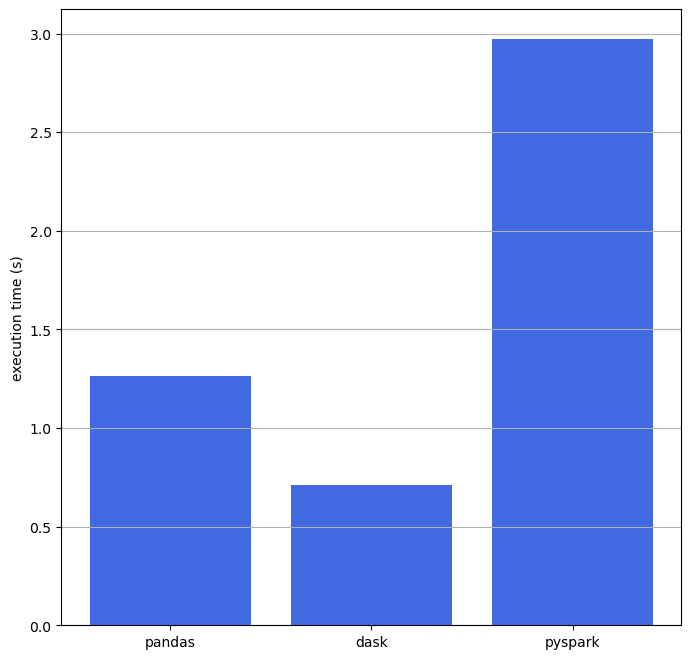

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.bar(range(3), [pandas_time, dask_time, spark_time], tick_label=['pandas', 'dask', 'pyspark'], color='royalblue')
plt.ylabel("execution time (s)")
plt.grid(axis='y')